# Simulations

This notebook introduces the simulations used in this project. 

It also creates some example simulation figures.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.sim import gen_power_spectrum

from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined
from neurodsp.utils import create_times, set_random_seed
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts import plot_time_series, plot_power_spectra

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))
from apm.core.db import APMDB

## Settings

In [3]:
# Set random seed
set_random_seed(111)

In [4]:
# Simulation Settings
n_seconds = 2
fs = 500

default_exp = -1.5
default_freq = 10

comps_osc = {'sim_powerlaw' : {'exponent' : default_exp},
             'sim_oscillation' : {'freq' : default_freq}}

comps_burst = {'sim_powerlaw' : {'exponent' : default_exp},
               'sim_bursty_oscillation' : {'freq' : default_freq}}

In [5]:
# Create a times vector for time series
times = create_times(n_seconds, fs)

In [6]:
# Plot settings
labels = {'xlabel' : '', 'ylabel' : ''}
tskwargs = {**labels, 'xlim' : [0, times[-1]]}

In [7]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FP = APMDB().figs_path + '/sims/'

In [8]:
# Set plot style
import seaborn as sns
sns.set_context('talk')

# Time Series Simulations

Time series are simulated using [NeuroDSP](https://neurodsp-tools.github.io/). 

#### Powerlaw Signal

In [9]:
sig_pow = sim_powerlaw(n_seconds, fs, default_exp, f_range=(1, None))

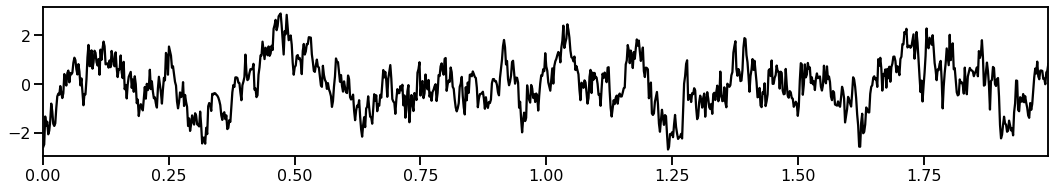

In [10]:
plot_time_series(times, sig_pow, **tskwargs, 
                 save_fig=SAVE_FIG, file_name='ts_powerlaw' + EXT, file_path=FP)

#### Powerlaw Signal with a Knee

In [11]:
sig_kn = sim_synaptic_current(n_seconds, fs)

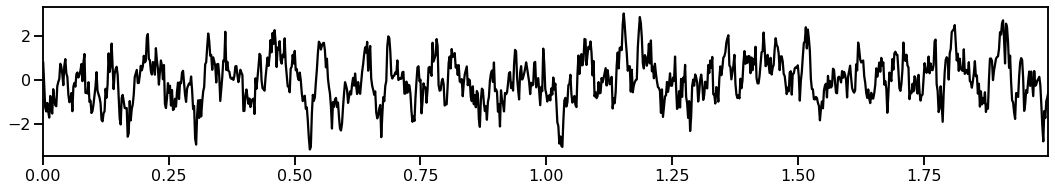

In [12]:
plot_time_series(times, sig_kn, **tskwargs, 
                 save_fig=SAVE_FIG, file_name='ts_knee' + EXT, file_path=FP)

#### Continuous Oscillation

In [13]:
sig_osc = sim_combined(n_seconds, fs, comps_osc)

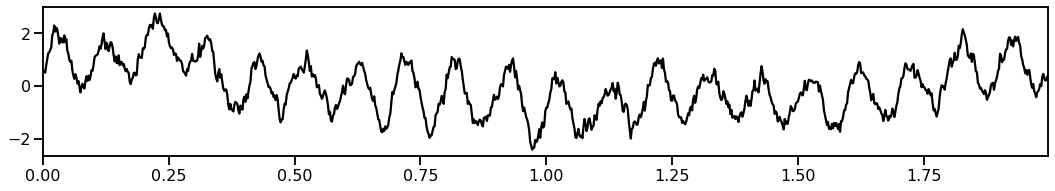

In [14]:
plot_time_series(times, sig_osc, **tskwargs, 
                 save_fig=SAVE_FIG, file_name='ts_comb' + EXT, file_path=FP)

#### Bursty Oscillation

In [15]:
sig_bu = sim_combined(n_seconds, fs, comps_burst)

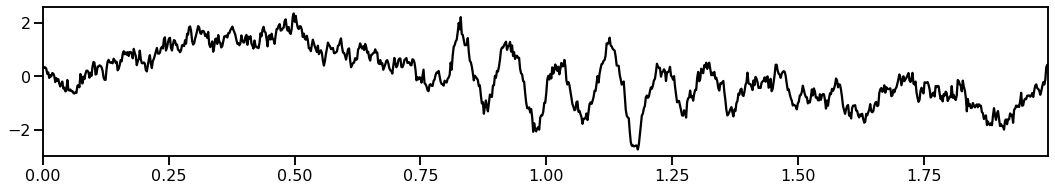

In [16]:
plot_time_series(times, sig_bu, **tskwargs, 
                 save_fig=SAVE_FIG, file_name='ts_burst' + EXT, file_path=FP)

### Power Spectrum of Simulated Time Series

In [17]:
# Calculate the power spectrum of a simulated time series
sig_freqs, sig_powers = compute_spectrum(sig_osc, fs, nperseg=250)

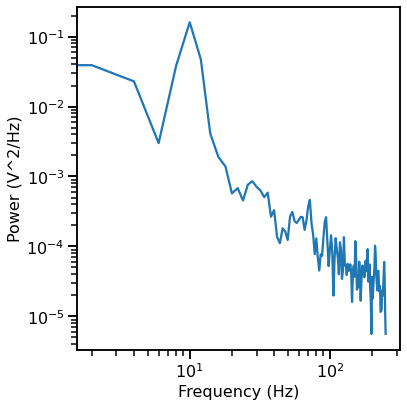

In [18]:
# Plot the power spectrum of the simulated time series
plot_power_spectra(sig_freqs, sig_powers)

# Power Spectrum Simulations

Power spectra are simulated using [FOOOF](https://fooof-tools.github.io/). 

In [19]:
def custom_psd_style(ax, **kwargs):
    """Define custom styling for the PSD plots."""
    
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)
    
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.tight_layout()

#### Single Peak & Fixed Mode

In [20]:
freqs, powers = gen_power_spectrum([3, 40], [1, 1], [10, 0.3, 1], nlv=0.025)

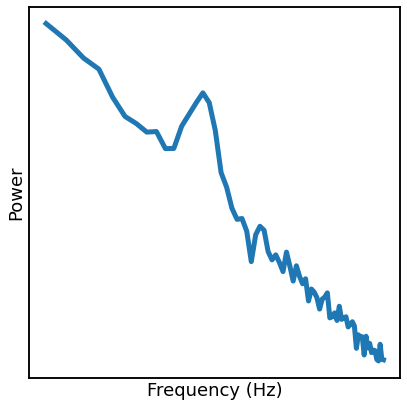

In [21]:
plot_power_spectra(freqs, powers, lw=5, ylabel='Power', custom_styler=custom_psd_style,
                   save_fig=SAVE_FIG, file_name='psd_fixed' + EXT, file_path=FP)

#### Multi-Peak & Knee Mode

In [22]:
freqs, powers = gen_power_spectrum([1, 75], [0, 400, 1], [[5, 0.025, 1], [30, 0.02, 4]], nlv=0.001)

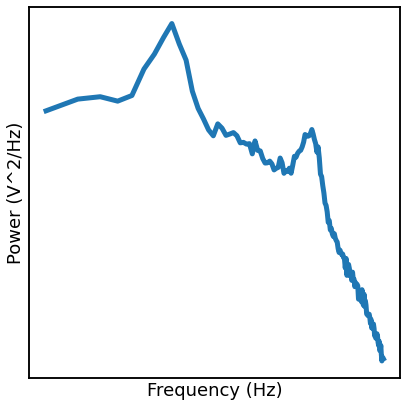

In [23]:
plot_power_spectra(freqs, powers, lw=5, custom_styler=custom_psd_style,
                   save_fig=SAVE_FIG, file_name='psd_knee' + EXT, file_path=FP)

### FOOOF Demo

[FOOOF](https://fooof-tools.github.io/) is a tool for parameterizing neural power spectra. 

Here we will briefly demonstrate applying FOOOF to an example spectrum. 

In [24]:
# Initialize a FOOOF model
fm = FOOOF(peak_width_limits=[1, 8], min_peak_height=0.1, verbose=False)

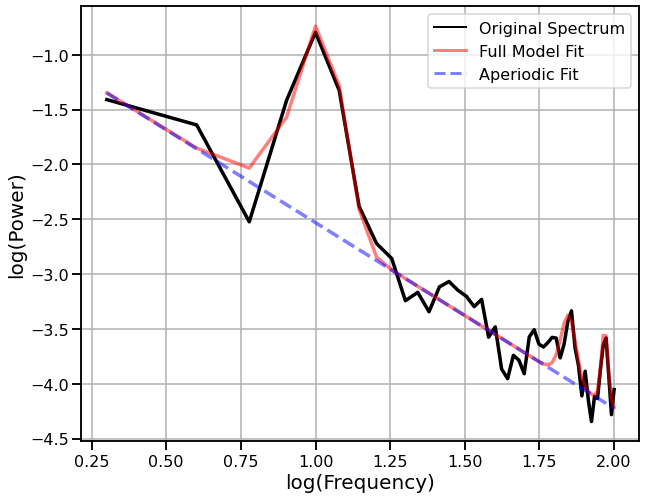

In [25]:
# Fit and plot the FOOOF model
fm.fit(sig_freqs, sig_powers, [1, 100])
fm.plot(plt_log=True)

# Aesthetic Tweaks
for line in plt.gca().get_lines():
    line.set_linewidth(3.5)
if SAVE_FIG: plt.savefig(FP + 'FOOOF_example' + EXT)

In [26]:
# Check the model fit values
fm.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 2.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.8379, 1.6930                                          
                                                                                                  
                                       3 peaks were found:                                        
          

### Simulating Power Law Signals through Spectral Rotation

The aperiodic components of the above time series simulations are created by spectrally rotating white noise. 

This section demonstrates how those simulations work. 

In [27]:
# Simulate a white noise signal
sig = sim_powerlaw(n_seconds, fs, exponent=0)

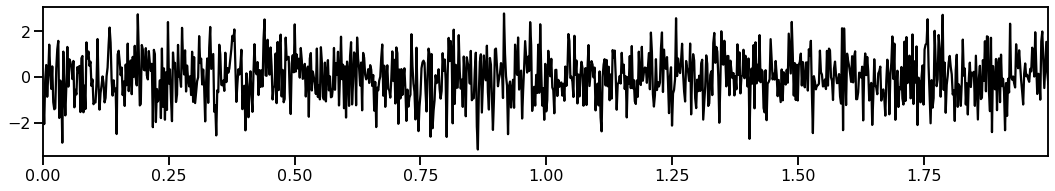

In [28]:
plot_time_series(times, sig, **tskwargs, 
                 save_fig=SAVE_FIG, file_name='rot_ts_pre' + EXT, file_path=FP)

In [29]:
# Compute the power spectrum of the signal
freqs, pows = compute_spectrum(sig, fs, nperseg=250, noverlap=100)

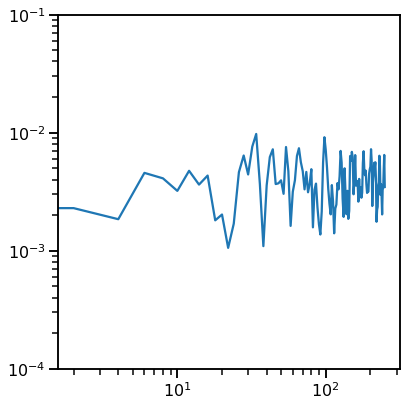

In [30]:
# Plot the power spectrum of the white noise signal
plot_power_spectra(freqs, pows, **labels, ylim=[0.0001, 0.1], 
                   save_fig=SAVE_FIG, file_name='rot_psd_pre' + EXT, file_path=FP)

In [31]:
# Rotate the spectrum to desired aperiodic exponent
pows_rot = rotate_powerlaw(freqs, pows, 1, f_rotation=100)

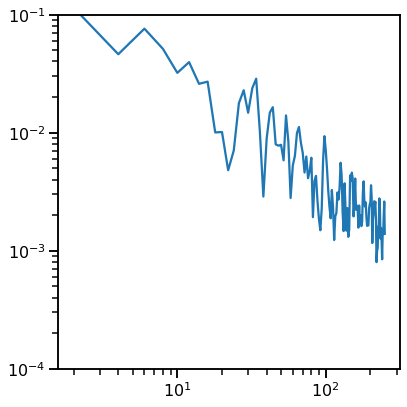

In [32]:
# Plot the power spectrum of the rotated signal
plot_power_spectra(freqs, pows_rot, **labels, ylim=[0.0001, 0.1], 
                   save_fig=SAVE_FIG, file_name='rot_psd_post' + EXT, file_path=FP)

In [33]:
# Get the rotated signal, back in the time domain
#   Note: this step directly uses the NDSP function, which rotates a new signal behind the scenes
sig = sim_powerlaw(n_seconds, fs, exponent=-1)

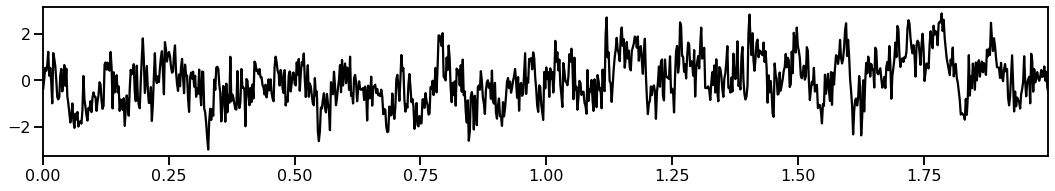

In [34]:
# Plot the time series of the rotated signal, with the desired aperiodic exponent
plot_time_series(times, sig, **tskwargs, 
                 save_fig=SAVE_FIG, file_name='rot_ts_post' + EXT, file_path=FP)